# 프로젝트 : 주식 예측에 도전해 보자  

목표 : ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보기. 

데이터 : Yahoo Finance에서 대한민국 대장주 삼성전자에 대한 과거 상장한 시점부터 가장 최근까지의 일자별 시세 데이터 가져와서 분석

# 삼성전자  - Samsung Electronics Co., Ltd. (005930.KS)

## STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

# 필요한 라이브러리를 불러옵니다
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler

In [2]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0


In [3]:
df = df.reset_index()

## STEP 2 : 각종 전처리 수행

- 결측치 처리
- 이상치 확인
- 로그 변환


### 이상치 확인

In [4]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64

In [5]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 5317
삭제 후 데이터 길이(일자수): 5311


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [7]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [8]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [9]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [10]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/stock_prediction/samsung/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"]) 

In [11]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
165/166 [============================>.] - ETA: 0s - loss: 1.4352 - mae: 1.4352
Epoch 00001: val_loss improved from inf to 0.79943, saving model to /home/ssac6/aiffel/stock_prediction/samsung/mymodel.ckpt
166/166 [==============================] - 6s 38ms/step - loss: 1.4324 - mae: 1.4324 - val_loss: 0.7994 - val_mae: 0.7994
Epoch 2/50
165/166 [============================>.] - ETA: 0s - loss: 0.3141 - mae: 0.3141
Epoch 00002: val_loss improved from 0.79943 to 0.76686, saving model to /home/ssac6/aiffel/stock_prediction/samsung/mymodel.ckpt
166/166 [==============================] - 6s 34ms/step - loss: 0.3131 - mae: 0.3131 - val_loss: 0.7669 - val_mae: 0.7669
Epoch 3/50
165/166 [============================>.] - ETA: 0s - loss: 0.3932 - mae: 0.3932
Epoch 00003: val_loss improved from 0.76686 to 0.46899, saving model to /home/ssac6/aiffel/stock_prediction/samsung/mymodel.ckpt
166/166 [==============================] - 6s 35ms/step - loss: 0.3916 - mae: 0.3916 - val_loss: 0.4

In [12]:
model.load_weights(checkpoint_path)

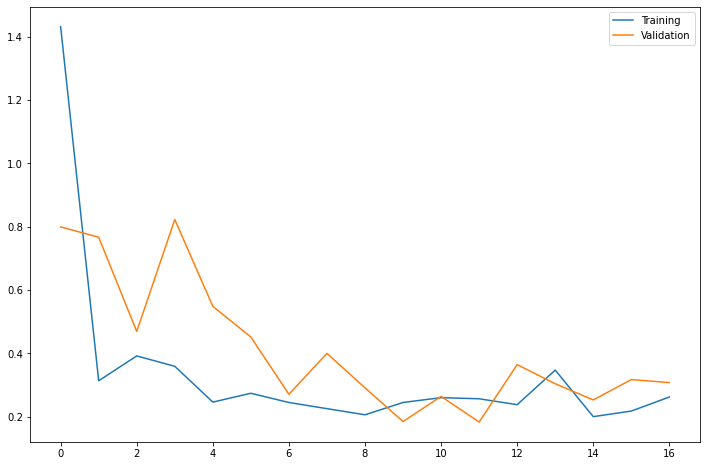

In [13]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

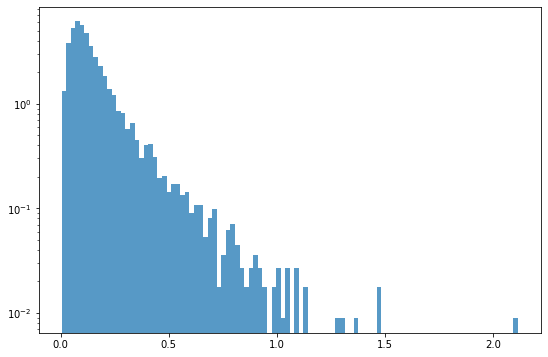

In [14]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [15]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

In [16]:
threshold = 0.9
threshold_over_df = test_df.loc[test_df.Loss>threshold]

In [17]:
threshold_over_df

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
12,2000-02-03,5250.0,5460.0,4970.0,5130.0,3997.524658,142765000.0,1.294444
32,2000-03-02,5880.0,5880.0,5520.0,5880.0,4581.958496,117750000.0,1.002211
33,2000-03-03,6200.0,6250.0,5880.0,6000.0,4675.465820,140990000.0,1.284019
162,2000-08-31,5900.0,5900.0,5380.0,5470.0,4262.466797,114120000.0,1.058027
174,2000-09-18,4010.0,4120.0,3700.0,3970.0,3093.600586,146305000.0,1.357399
196,2000-10-18,2540.0,2760.0,2420.0,2730.0,2127.337402,164215000.0,1.467853
197,2000-10-19,2730.0,3050.0,2690.0,2900.0,2259.809082,137720000.0,1.051042
199,2000-10-23,3490.0,3520.0,3160.0,3200.0,2493.582520,139960000.0,0.980992
202,2000-10-26,2930.0,3030.0,2740.0,2890.0,2252.016602,133290000.0,0.931108
203,2000-10-27,2890.0,2890.0,2890.0,2890.0,2252.016602,0.0,1.057077


/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


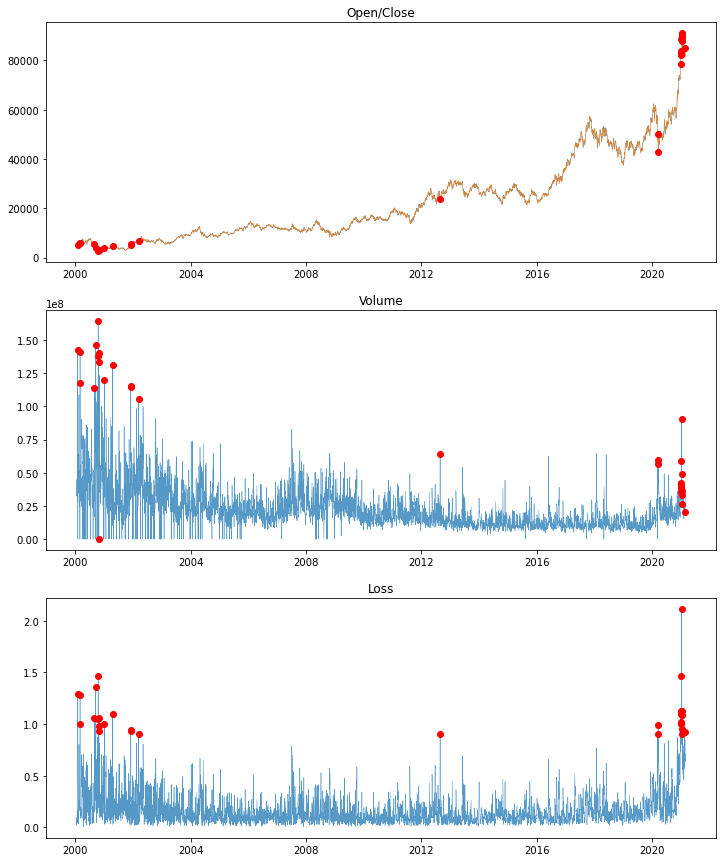

In [18]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312) 

ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])  

### 이상치 처리

In [19]:
t_index = threshold_over_df.index
df = df.drop(t_index)

In [20]:
ts = df.set_index('Date')
ts = ts['Close']

In [21]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 로그변환 

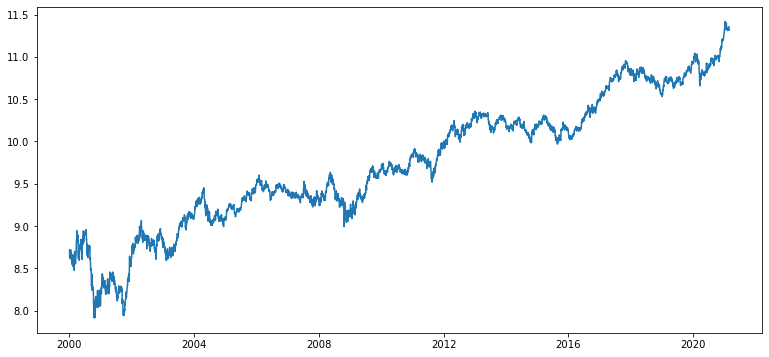

In [23]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [166]:
def plot_rolling_statistics(timeseries, window):
    
    rolmean = timeseries.rolling(window=window).mean() #이동평균시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다. 
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

In [167]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

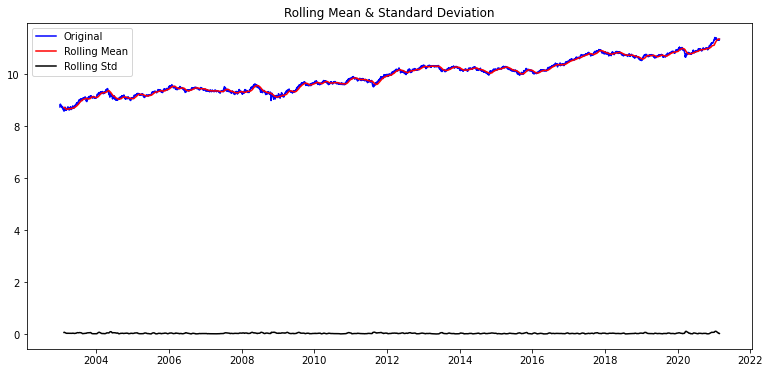

In [63]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=30)

In [27]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.286106
p-value                           0.927449
#Lags Used                        4.000000
Number of Observations Used    5277.000000
Critical Value (1%)              -3.431590
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


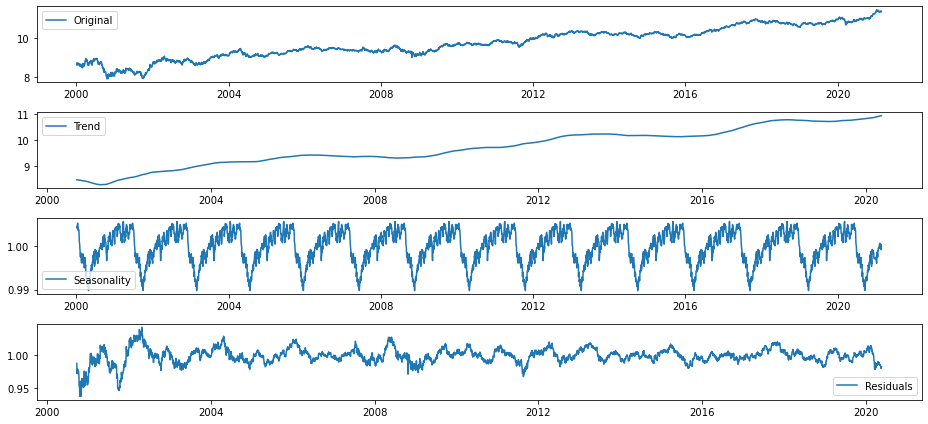

In [28]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 365) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


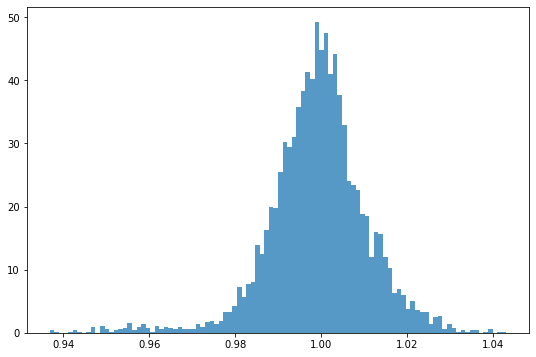

In [29]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(residual, 100, density=True, alpha=0.75)

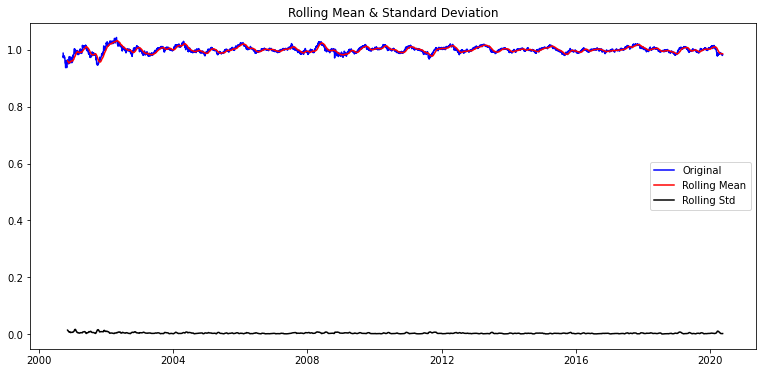

In [30]:
# Residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual, window=30)

In [31]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.212489e+00
p-value                        5.464865e-08
#Lags Used                     4.000000e+00
Number of Observations Used    4.913000e+03
Critical Value (1%)           -3.431682e+00
Critical Value (5%)           -2.862128e+00
Critical Value (10%)          -2.567083e+00
dtype: float64


In [32]:
residual.head()

Date
2000-09-21    0.987603
2000-09-22    0.972137
2000-09-25    0.979310
2000-09-26    0.975760
2000-09-27    0.977295
Name: resid, dtype: float64

## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리  

In [33]:
ts_log = ts_log['2003-01-01':]

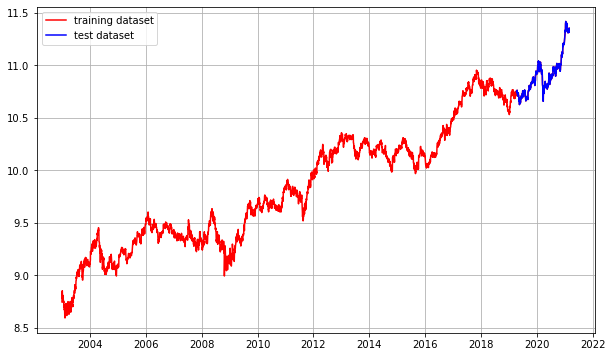

In [34]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [35]:
train_data.shape

(4064,)

## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

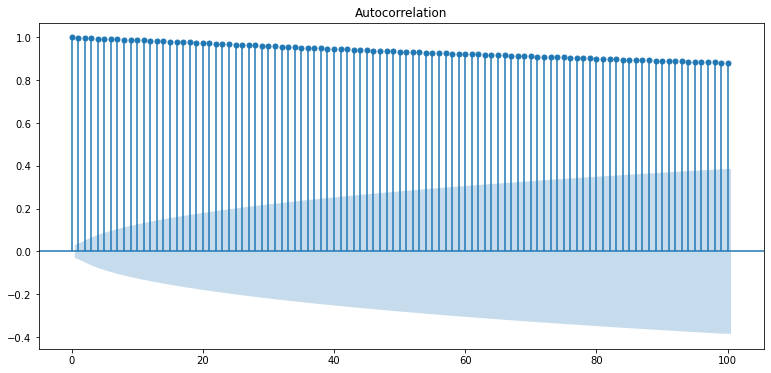

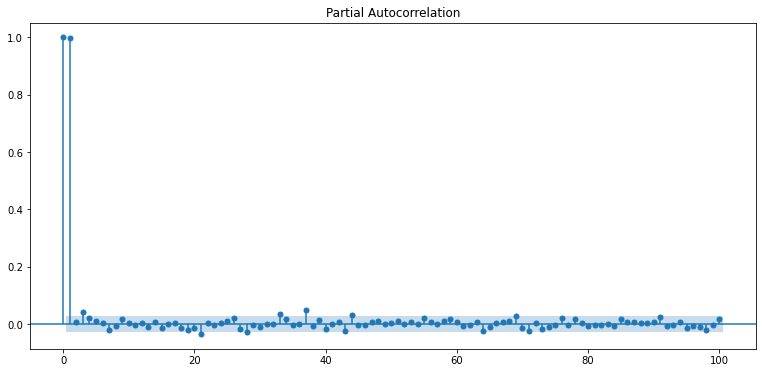

In [36]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log, lags=100)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=100)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -37.205406
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    4511.000000
Critical Value (1%)              -3.431800
Critical Value (5%)              -2.862181
Critical Value (10%)             -2.567111
dtype: float64


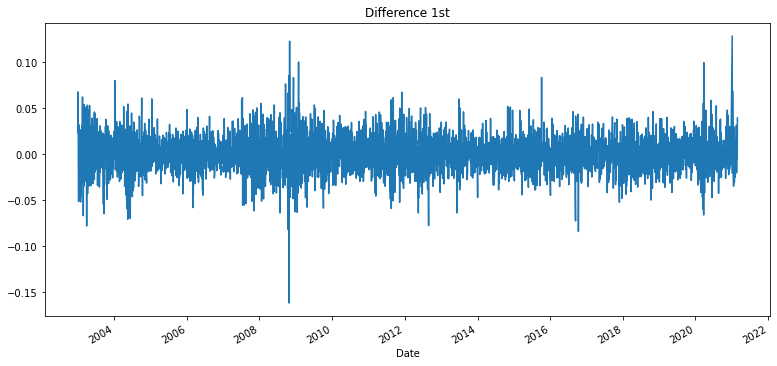

In [37]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)


In [38]:
train_data.head()

Date
2003-01-01    8.745125
2003-01-02    8.768730
2003-01-03    8.836374
2003-01-06    8.852236
2003-01-07    8.832004
Name: Close, dtype: float64

In [39]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4063
Model:                 ARIMA(2, 1, 0)   Log Likelihood               10355.275
Method:                       css-mle   S.D. of innovations              0.019
Date:                Mon, 01 Mar 2021   AIC                         -20702.549
Time:                        23:50:23   BIC                         -20677.310
Sample:                             1   HQIC                        -20693.610
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.722      0.085   -6.82e-05       0.001
ar.L1.D.Close     0.0407      0.016      2.601      0.009       0.010       0.071
ar.L2.D.Close    -0.0789      0.016     

/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

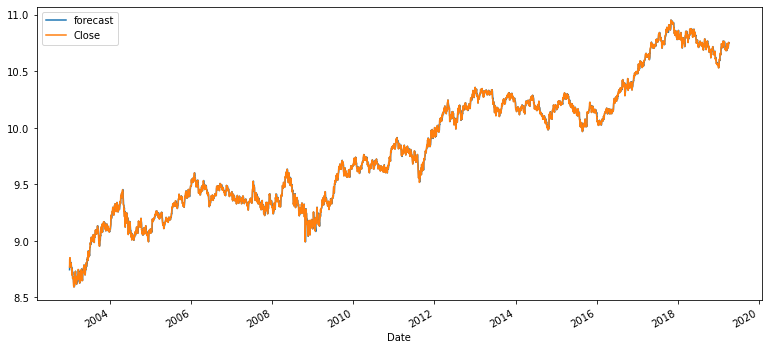

In [40]:
fitted_m.plot_predict();

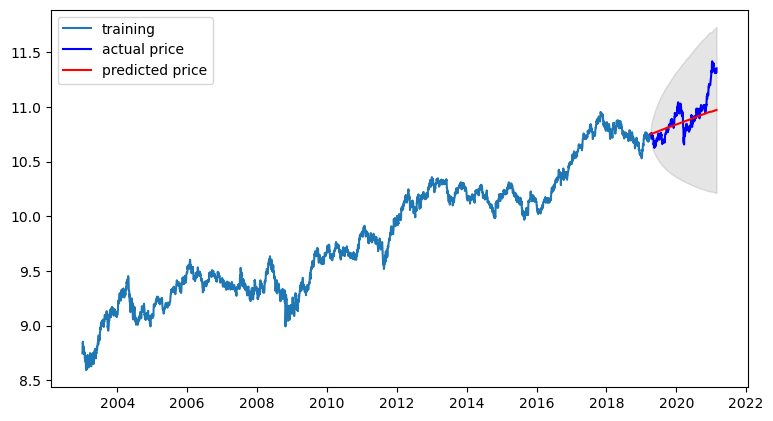

In [41]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 예측모델 오차율  8.92% 

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def estimator_func(v_test_d, v_fc):
    mse = mean_squared_error(np.exp(v_test_d), np.exp(v_fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(v_test_d), np.exp(v_fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(v_test_d), np.exp(v_fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(v_fc) - np.exp(v_test_d))/np.abs(np.exp(v_test_d)))
    print('MAPE: {:.2f}%'.format(mape*100))
    
estimator_func(test_data, fc)

MSE:  81482749.9672602
MAE:  5609.701821122574
RMSE:  9026.779601123548
MAPE: 8.92%


## STEP 7 : 다른 주식 종목 예측해 보기   
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

## STEP 7-1 : 한컴MDS - Hancom MDS Inc. (086960.KQ)

### STEP 7-1-1 : 시계열 데이터 준비  
야후에서 데이터가 나오지 않아서 FinanceDataReader  모듈을 이용해 데이터를 준비했다. 

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import FinanceDataReader as fdr

hanmds = fdr.DataReader('086960') 

In [169]:
hanmds.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2006-09-26,13358,15343,12290,15343,1971229,NaN
2006-09-27,15725,16106,13740,13969,750913,-0.089552
2006-09-28,14503,15572,14198,14923,525274,0.068294
2006-09-29,14885,15076,13816,13816,206147,-0.074181
2006-10-02,13893,14045,12900,13053,181752,-0.055226


### STEP 7-1-2 : 각종 전처리 수행

In [170]:
df = hanmds.reset_index()

In [171]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Change    1
dtype: int64

In [172]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 3563
삭제 후 데이터 길이(일자수): 3562


Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

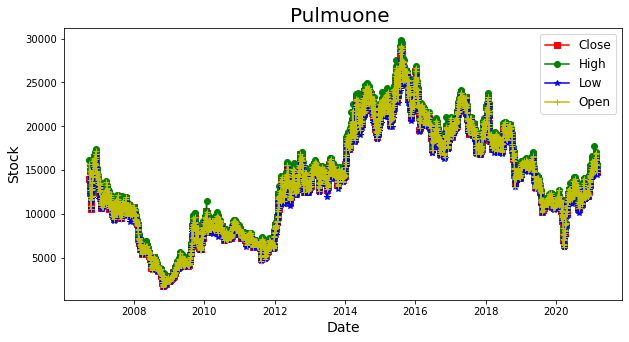

In [173]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('Pulmuone ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [174]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000
mean,13751.268116,14007.285632,13469.549769,13729.299966,88175.634655
std,6009.205394,6080.811318,5921.650385,5999.049926,67469.175739
min,2337.100000,2472.000000,2233.700000,2341.200000,9031.970000
25%,8612.450000,8788.025000,8426.925000,8579.575000,42165.492500
50%,13685.750000,13969.750000,13352.250000,13656.750000,67771.290000
75%,18910.000000,19206.750000,18574.375000,18880.625000,117975.185000
max,26554.500000,27160.000000,25965.000000,26533.000000,426498.790000


In [175]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -16.51666312  -17.25473354  -16.9716681   -17.7946592  -542.07088652]


array([[-0.98588998, -1.19084213, -3.22063417, -3.48567091,  5.04526201],
       [-2.51525529, -1.82825926, -2.54749677, -2.11118638,  3.02865621],
       [-1.9519985 , -2.41172949, -3.00021158, -3.59093958,  0.185982  ],
       ...,
       [-1.20035313, -1.7444234 , -1.83078402, -2.24174871, -1.66190965],
       [-1.84602641, -2.02152004, -1.45668159, -1.47427845, -2.28519758],
       [-2.27170511, -2.44553302, -2.33115121, -2.18862304, -2.12812599]])

In [176]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.  

[1 1 1 ... 1 1 1]


In [177]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:138',
 'group:1-count:505',
 'group:2-count:329',
 'group:3-count:3',
 'group:4-count:35',
 'group:5-count:74',
 'group:6-count:533',
 'group:7-count:111',
 'group:8-count:10',
 'group:9-count:86',
 'group:10-count:717',
 'group:11-count:184',
 'group:12-count:777',
 'group:13-count:47',
 'group:14-count:13']

In [178]:
dr_df = df[(kmeans.labels_==3)|(kmeans.labels_==8)]

In [179]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.287893,-0.444177,-0.240629,-0.331831,-1.234044
1,0.836094,0.799136,0.841244,0.791344,-0.035449
2,-1.362920,-1.389271,-1.386391,-1.355522,-0.257660
3,1.026637,2.353050,0.937839,1.443497,17.888767
4,0.857582,1.609608,0.755320,1.259612,3.983346
5,1.578383,1.985656,1.533004,1.815922,1.052737
6,-0.714754,-0.711407,-0.731114,-0.713776,-0.078936
7,0.117059,0.576970,0.170370,0.517710,1.222912
8,-5.776879,-5.563028,-6.006903,-5.896086,-0.520507
9,-2.358164,-2.356728,-2.498846,-2.392623,-0.015180


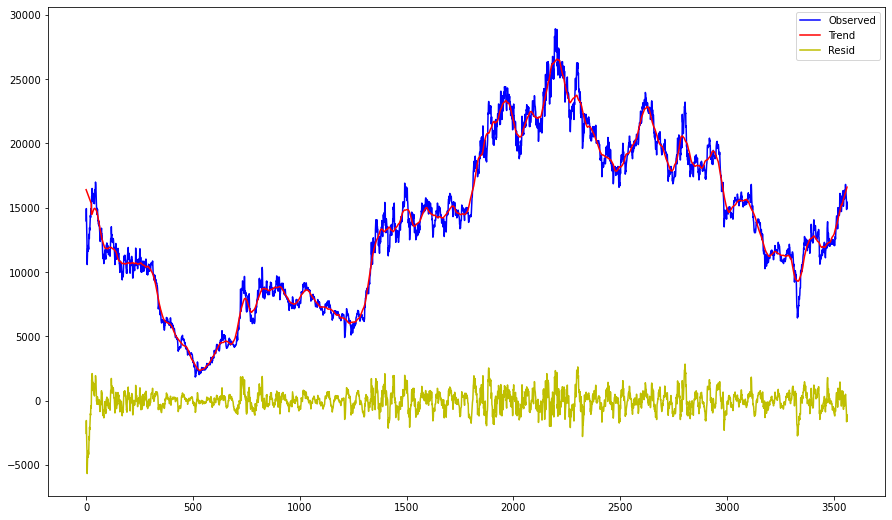

In [180]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.Close.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.Close.plot(ax=ax,label='Resid', legend=True, color='y')
plt.show()

In [181]:
df = df.drop(dr_df.index)

In [182]:
hanmds_ts = df.set_index('Date')
hanmds_ts = hanmds_ts['Close']

hanmds_ts.head()

Date
2006-09-27    13969
2006-09-28    14923
2006-09-29    13816
2006-10-02    13053
2006-10-20    12938
Name: Close, dtype: int64

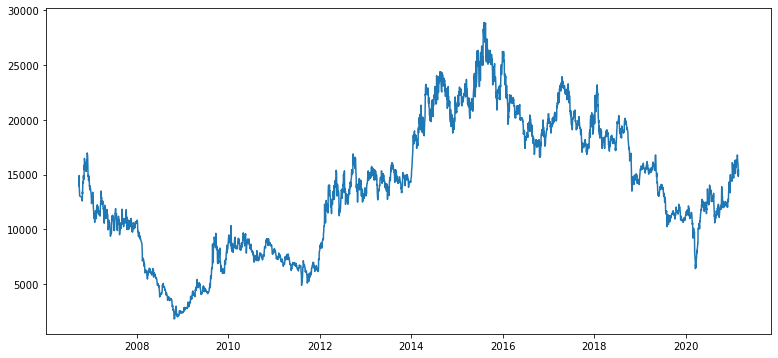

In [183]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(hanmds_ts)

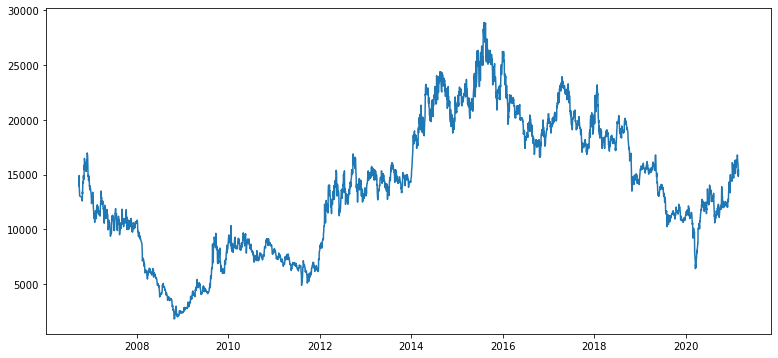

In [184]:
# 결측치 처리
hanmds_ts=hanmds_ts.interpolate(method='time')
hanmds_ts[hanmds_ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 
plt.plot(hanmds_ts)

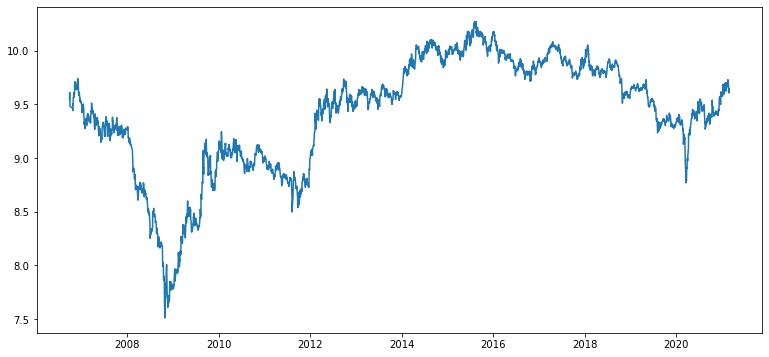

In [185]:
# 로그 변환
hanmds_ts_log = np.log(hanmds_ts)
plt.plot(hanmds_ts_log)

### STEP 7-1-3 : 시계열 안정성 분석

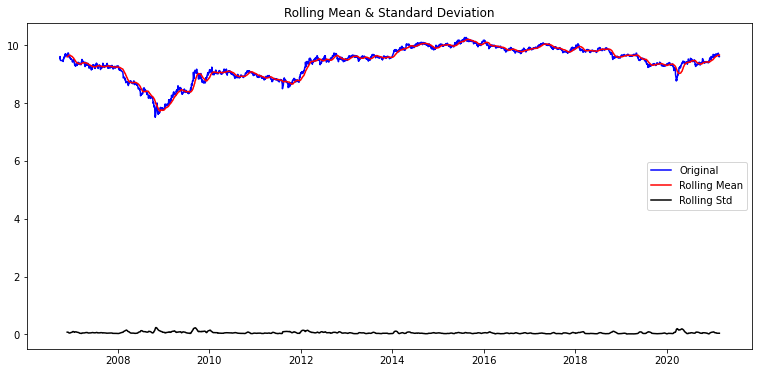

In [186]:
# 정성적 그래프 분석
plot_rolling_statistics(hanmds_ts_log, window=30)

In [187]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(hanmds_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.586158
p-value                           0.490543
#Lags Used                        0.000000
Number of Observations Used    3548.000000
Critical Value (1%)              -3.432194
Critical Value (5%)              -2.862355
Critical Value (10%)             -2.567204
dtype: float64


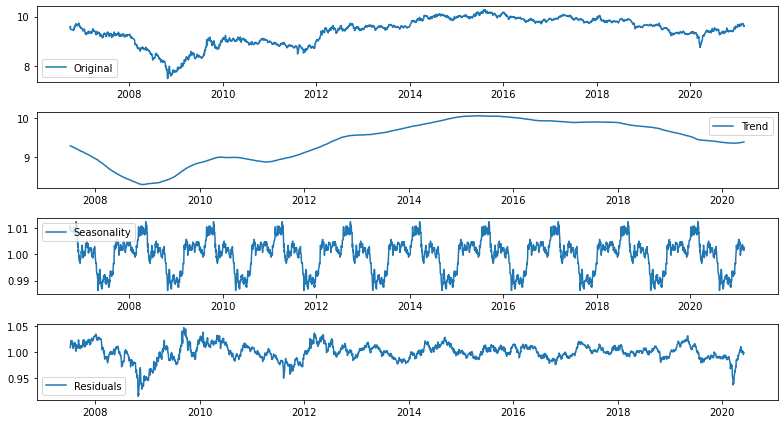

In [188]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(hanmds_ts_log,  model='multiplicative', period = 365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(hanmds_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [189]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                   -5.154908
p-value                           0.000011
#Lags Used                        3.000000
Number of Observations Used    3181.000000
Critical Value (1%)              -3.432407
Critical Value (5%)              -2.862449
Critical Value (10%)             -2.567254
dtype: float64


In [190]:
residual.describe()

count    3185.000000
mean        0.999227
std         0.015789
min         0.914853
25%         0.990408
50%         0.999946
75%         1.009460
max         1.046406
Name: resid, dtype: float64

Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 주고 있다. 

### STEP 7-1-4 : 학습, 테스트 데이터셋 생성

In [158]:
hanmds_ts_log = hanmds_ts_log['2010-01-01':]

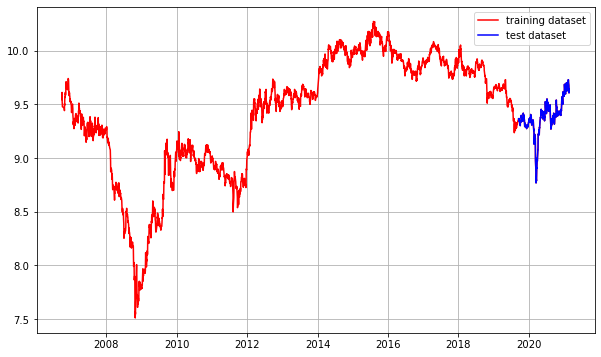

In [191]:
train_data, test_data = hanmds_ts_log[:int(len(hanmds_ts_log)*0.9)], hanmds_ts_log[int(len(hanmds_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(hanmds_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 7-1-5 : 적정 ARIMA 모수 찾기

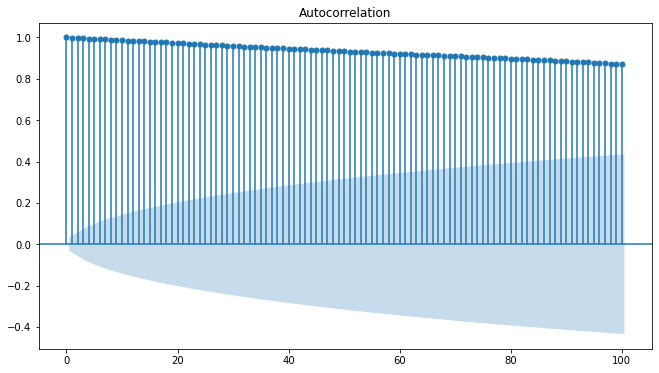

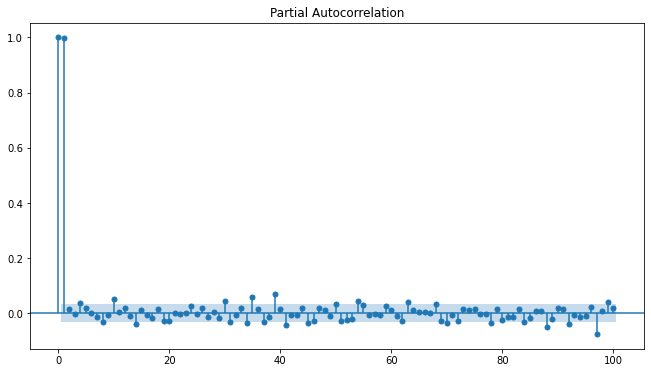

In [192]:
plot_acf(hanmds_ts_log, lags=100)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(hanmds_ts_log, lags=100)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -35.521476
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    3545.000000
Critical Value (1%)              -3.432196
Critical Value (5%)              -2.862356
Critical Value (10%)             -2.567204
dtype: float64


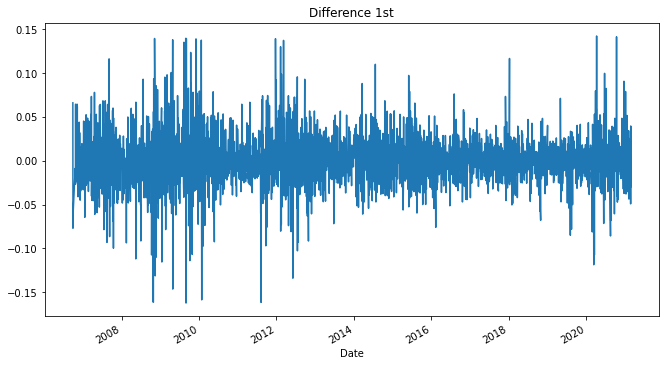

In [193]:
# 1차 차분 구하기
diff_1 = hanmds_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다. 반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보인다. 

### STEP 7-1-6 : ARIMA 모델 훈련과 테스트

In [194]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3193
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6783.694
Method:                       css-mle   S.D. of innovations              0.029
Date:                Tue, 02 Mar 2021   AIC                         -13559.389
Time:                        00:08:00   BIC                         -13535.114
Sample:                             1   HQIC                        -13550.685
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.015e-05      0.001     -0.120      0.904      -0.001       0.001
ar.L1.D.Close    -0.0242      0.018     -1.367      0.172      -0.059       0.010
ar.L2.D.Close     0.0036      0.018     

/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

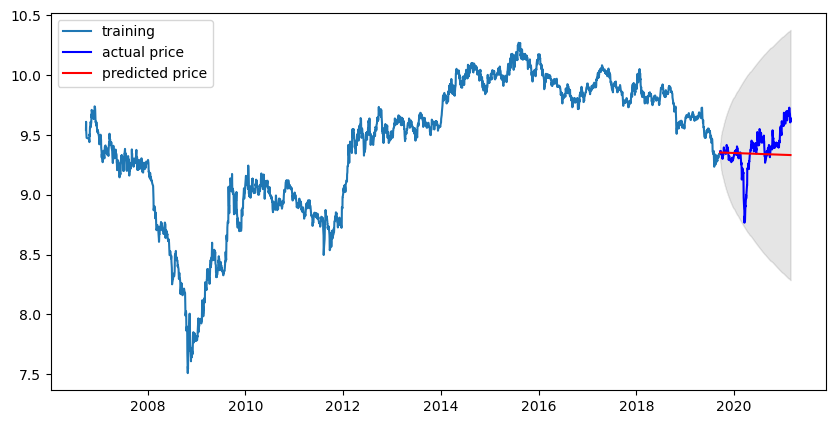

In [195]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [196]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3887978.233815802
MAE:  1387.7881892764144
RMSE:  1971.7956876450971
MAPE: 11.64%


## STEP 7-1 엑셈 - EXEM Co., Ltd. (205100.KQ)

### STEP 7-1-1 : 시계열 데이터 준비

In [105]:
import FinanceDataReader as fdr
asem = fdr.DataReader('205100')

In [106]:
asem.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2014-11-07,4500,5170,4500,5170,2806442,NaN
2014-11-10,5200,5940,4800,5560,4375728,0.075435
2014-11-11,5500,6160,5100,5140,2586968,-0.075540
2014-11-12,5200,5210,4800,4850,667845,-0.056420
2014-11-13,4860,5530,4800,5130,1266068,0.057732


In [107]:
df = asem.reset_index()

### STEP 7-1-2 : 각종 전처리 수행

In [108]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Change    1
dtype: int64

In [109]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 1550
삭제 후 데이터 길이(일자수): 1549


Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

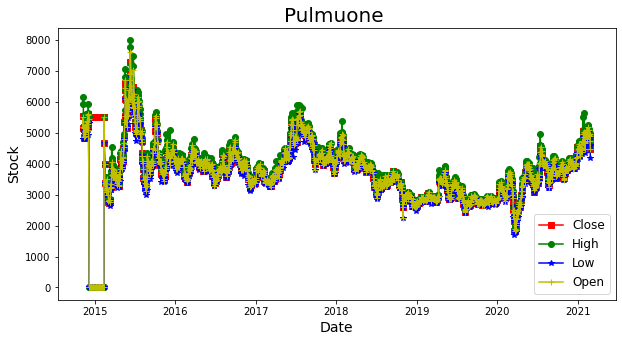

In [110]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('Pulmuone ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

In [111]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,1549.000000,1549.000000,1549.000000,1549.000000,1.549000e+03
mean,3656.235396,3751.382345,3568.411184,3872.717128,5.331560e+05
std,894.388193,929.334736,866.181210,746.474710,5.133116e+05
min,343.450000,345.800000,324.150000,2771.100000,-1.741934e+05
25%,3139.450000,3221.350000,3070.350000,3311.350000,1.855616e+05
50%,3783.500000,3874.100000,3698.450000,3854.500000,3.411047e+05
75%,4162.850000,4271.150000,4043.550000,4200.550000,7.754035e+05
max,5902.900000,6180.600000,5630.200000,6554.405128,2.241022e+06


In [112]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[  44.16624617   46.44093652   42.05230396  -13.55153168 2818.40213936]


array([[ 7.08672797,  7.81624397,  6.80755739, -3.2474039 ,  3.79232954],
       [ 7.55934608,  8.18762829,  7.30352053, -4.23424873,  2.38556897],
       [ 7.11293534,  6.76873803,  6.8265071 , -5.01344005,  0.73325767],
       ...,
       [ 0.03130198, -0.21548375, -0.2898701 , -0.87183802, -0.9902999 ],
       [-0.22784614, -0.40726189, -0.29296856, -0.87582654, -1.18350921],
       [-0.58416217, -0.79206727, -0.91998054, -1.50926503, -1.21557212]])

In [113]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.  

[1 1 1 ... 0 0 0]


In [114]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1528   21]


In [115]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:324',
 'group:1-count:21',
 'group:2-count:275',
 'group:3-count:1',
 'group:4-count:24',
 'group:5-count:82',
 'group:6-count:113',
 'group:7-count:13',
 'group:8-count:3',
 'group:9-count:85',
 'group:10-count:27',
 'group:11-count:139',
 'group:12-count:15',
 'group:13-count:412',
 'group:14-count:15']

In [116]:
dr_df = df[(kmeans.labels_==3)|(kmeans.labels_==8)]

In [117]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.372826,-0.363396,-0.369971,-0.389984,-0.097715
1,6.988570,6.995232,7.009679,-2.839979,0.610212
2,0.278166,0.264695,0.277908,0.676008,0.064542
3,0.332114,1.513186,0.450495,1.702453,22.884902
4,0.320664,0.634904,0.329306,0.929620,2.091237
5,-1.068292,-1.040089,-1.079116,-1.670460,-0.017117
6,0.103341,0.021559,0.133776,0.260165,-0.725412
7,-0.153996,0.189224,-0.190639,0.204041,4.202171
8,-0.168527,0.949021,-0.247862,0.596652,11.473945
9,0.755022,0.771716,0.743824,1.578664,0.129748


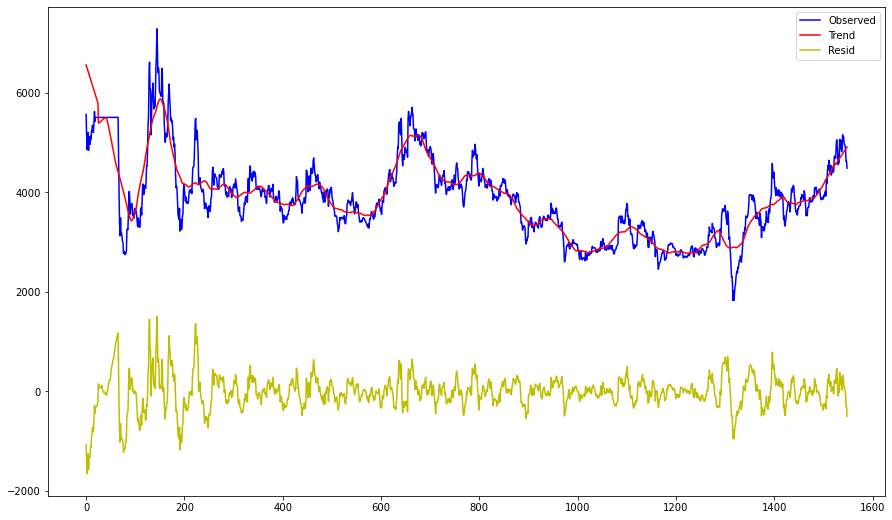

In [118]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.Close.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.Close.plot(ax=ax,label='Resid', legend=True, color='y')
plt.show()

In [119]:
df = df.drop(dr_df.index)

In [120]:
skinno_ts = df.set_index('Date')
skinno_ts = skinno_ts['Close']

skinno_ts.head()

Date
2014-11-10    5560
2014-11-11    5140
2014-11-12    4850
2014-11-13    5130
2014-11-14    5200
Name: Close, dtype: int64

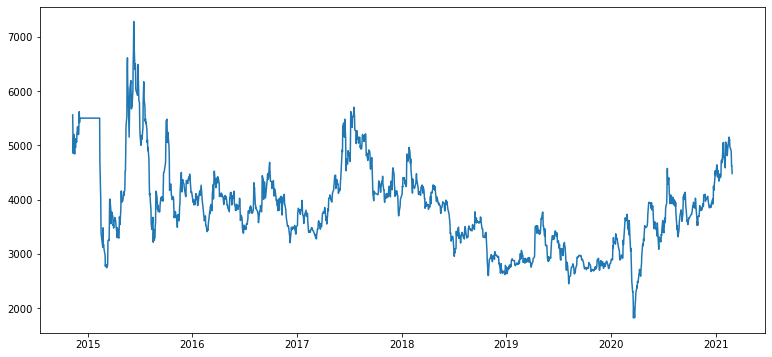

In [121]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(skinno_ts)

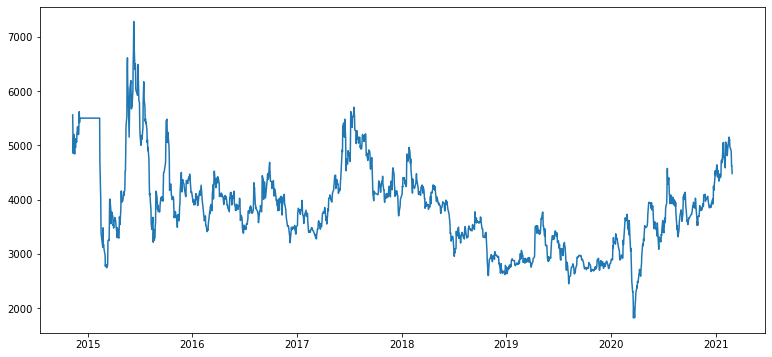

In [122]:
# 결측치 처리
skinno_ts=skinno_ts.interpolate(method='time')
skinno_ts[skinno_ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 
plt.plot(skinno_ts)

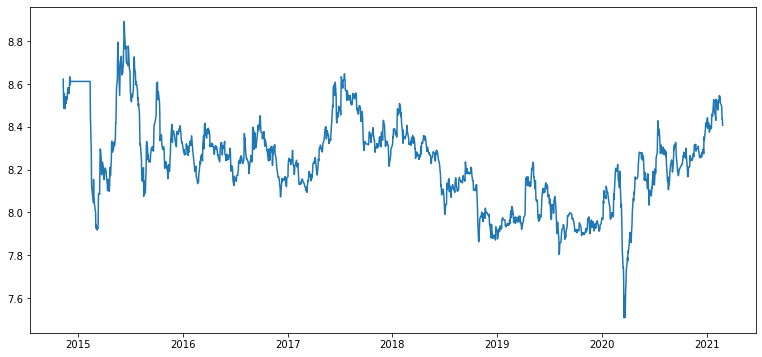

In [123]:
# 로그 변환
skinno_ts_log = np.log(skinno_ts)
plt.plot(skinno_ts_log)

### STEP 7-1-3 : 시계열 안정성 분석

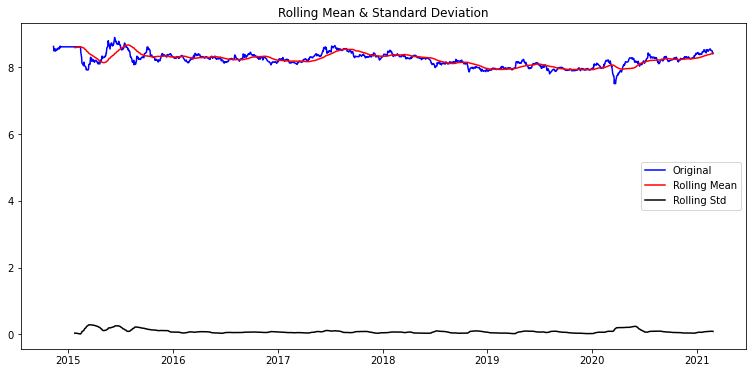

In [124]:
# 정성적 그래프 분석
plot_rolling_statistics(skinno_ts_log, window=52)

In [125]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(skinno_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -3.862432
p-value                           0.002329
#Lags Used                        5.000000
Number of Observations Used    1539.000000
Critical Value (1%)              -3.434606
Critical Value (5%)              -2.863420
Critical Value (10%)             -2.567771
dtype: float64


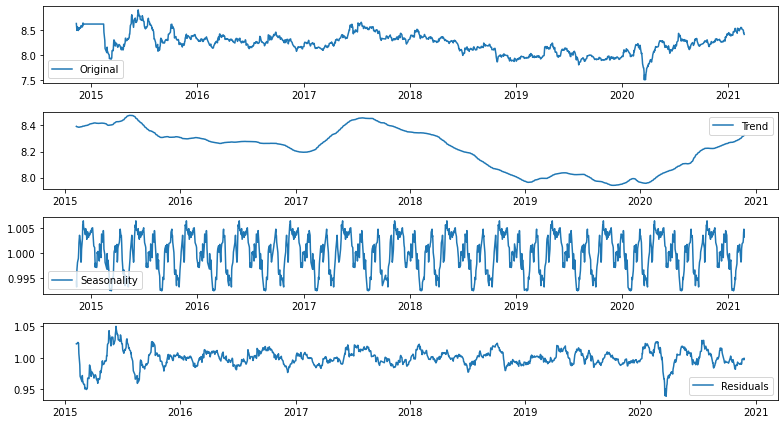

In [126]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(skinno_ts_log,model='multiplicative', period = 120)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(skinno_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [127]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.428138e+00
p-value                        6.466593e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.410000e+03
Critical Value (1%)           -3.434996e+00
Critical Value (5%)           -2.863592e+00
Critical Value (10%)          -2.567862e+00
dtype: float64


### STEP 7-1-4 : 학습, 테스트 데이터셋 생성

In [128]:
skinno_ts_log = skinno_ts_log['2020-05-01':]

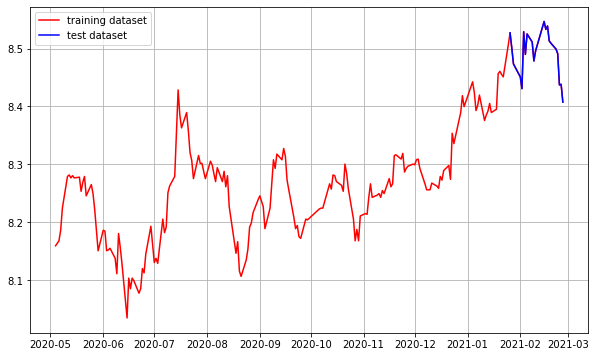

In [129]:
train_skinno_data, test_skinno_data = skinno_ts_log[:int(len(skinno_ts_log)*0.9)], skinno_ts_log[int(len(skinno_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(skinno_ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_skinno_data, c='b', label='test dataset')
plt.legend()

### STEP 7-1-5 : 적정 ARIMA 모수 찾기

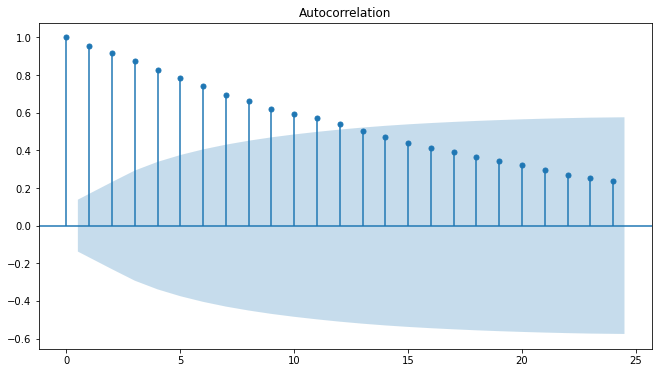

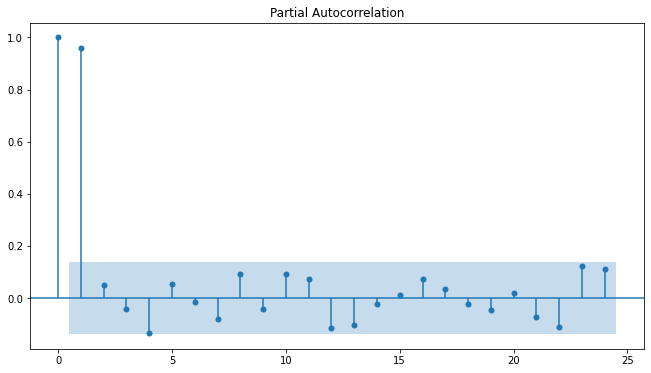

In [130]:
plot_acf(skinno_ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(skinno_ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.540260e+01
p-value                        3.200449e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64


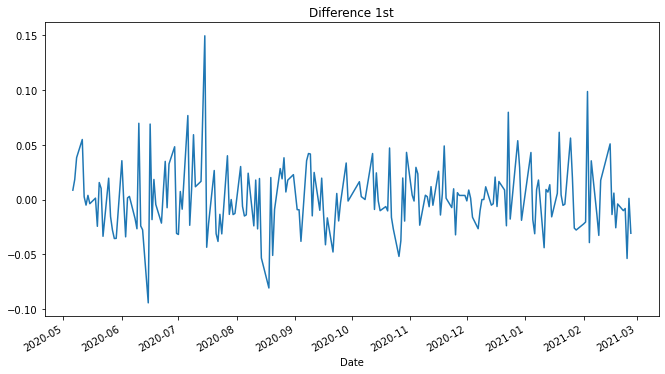

In [131]:
# 1차 차분 구하기
diff_1 = skinno_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



### STEP 7-1-6 : ARIMA 모델 훈련과 테스트

In [132]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_skinno_data, order=(2,1,0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  180
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 375.730
Method:                       css-mle   S.D. of innovations              0.030
Date:                Tue, 02 Mar 2021   AIC                           -743.460
Time:                        00:01:43   BIC                           -730.688
Sample:                             1   HQIC                          -738.281
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.002      0.902      0.367      -0.002       0.006
ar.L1.D.Close    -0.0763      0.075     -1.017      0.309      -0.223       0.071
ar.L2.D.Close     0.0244      0.075     

/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac6/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provid

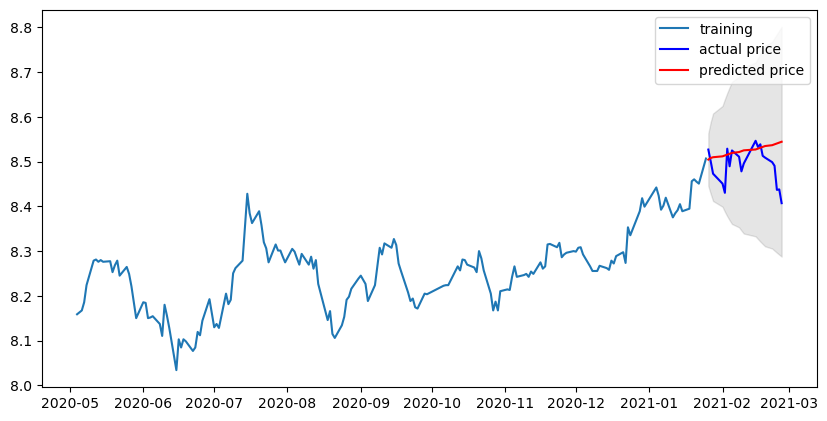

In [133]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_skinno_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_skinno_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_skinno_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_skinno_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_skinno_data, label='training')
plt.plot(test_skinno_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

mse = mean_squared_error(np.exp(test_skinno_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_skinno_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_skinno_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_skinno_data))/np.abs(np.exp(test_skinno_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  69940.23193849303
MAE:  198.17505908490915
RMSE:  264.46215596658254
MAPE: 4.20%


## 느낀점  
시계열은 정성적 평가가 많이 들어가는 분석인거 같다.   
모델 평가 기준을 맞추기 힘들었다.    
2008년 금융위기와 2020년이후의 코로나위기에 대한 데이터는 이상치이지만, 특이치로 쉽게 제거할 수 없는 데이터라 처리에 대한 고민이 되었다.   
삼성주식은 이상치에 대한 분석을 LSTM 모델을 적용해 살펴보았고,   
한컴MDS와 엑셈은 KNN으로 이상치를 분석해 보았다.   
acf와 pacf 는 거의 비슷하게 acf 곡선은 점차 하강하는 곡선이였고, pacf 는 lag=1에서 떨어지는 그래프를 도출되었다.   
그래서 ARIMA 모형에 적용할 p,q,r은 다 비슷하게 p=1, r=1, q=0 을 적용하였다. 이때의 AIC 값이 가장 작게 나왔다.     
ARIMA 모델이외에 prophet와 LSTM 모델로 학습을 진행해 보았는데, 기재하진 않았다.  
prophet을 적용했다고 해서 MAPE 값이 좋아지는 것은 아니였기 때문이다.   
데이터에 대한 깊은 이해가 필요하고, 데이터를 분석하기 위한 배경지식이 많아야겠다는 생각을 했다. 아직 나에겐 역부족이다.   